# Observing Returns In Cryptocurrencies 
> Various observations about Bitcoin, Ethereum and Cardano

- toc: false
- badges: false
- comments: true
- categories: [Finance]
- image: images/chart-preview.png


In [2]:
#hide
#@title imports
# !pip install ta
# !pip install pykalman
!pip install PyPortfolioOpt
!pip install pandas-datareader
!pip install pandas
# !pip install matplotlib
# !pip install fast-ta
!pip install yfinance
!pip install mplfinance
# 
# !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
# !tar -xzvf ta-lib-0.4.0-src.tar.gz
# %cd ta-lib
# !./configure --prefix=/usr
# !make
# !make install
# !pip install Ta-Lib
# import talib

# !pip install ta
# import ta 

import numpy as np
import pandas as pd
import time
import matplotlib.ticker as ticker

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
import random
sns.set()

# More Plotting libaries 
from mplfinance.original_flavor import candlestick_ohlc
from matplotlib.pylab import date2num
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

# libraries for Data Download
import datetime
from pandas_datareader import data as pdr
import yfinance as yf

# regression
from sklearn.linear_model import LinearRegression
# from datetime import datetime
import sklearn.preprocessing 
# !pip install optuna
# import optuna
# import joblib
from sklearn import linear_model
from sklearn import model_selection

from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

     |████████████████████████████████| 61kB 7.0MB/s 
     |████████████████████████████████| 1.3MB 27.2MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for cvxpy: filename=cvxpy-1.1.13-cp37-cp37m-linux_x86_64.whl size=2736111 sha256=b716fa322ce008c94cac19f4abb47ecfeb1627d3748f972b201adfa73178661a
  Stored in directory: /root/.cache/pip/wheels/f9/78/00/f29636789ee83434953b5442f16ec3f9834a68e7fd0393c220
Successfully built cvxpy
  Found existing installation: cvxpy 1.0.31
    Uninstalling cvxpy-1.0.31:
      Successfully uninstalled cvxpy-1.0.31
     |████████████████████████████████| 6.3MB 24.0MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23455 sha256=ee553a8ccb14b12c458c333eec82f0b72195cb419b19a092576bc602bceb0fcb
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
 

In [18]:
#hide
#@title logfit

def logfit(tickax,inception):
  data = pdr.get_data_yahoo(tickax, interval = '1d', period = "9y",progress=False)
  y =  np.array(data['Adj Close'])

  x = pd.date_range(start=inception,end=data.reset_index()['Date'][len(data)-1].strftime('%Y-%m-%d'),freq='D')
  x = pd.DataFrame(data={'Date':x})
  x = x.set_index('Date')

  df = pd.concat([data,x],axis=1)


  df = df.fillna(0)

  X = (df.index - df.index[0]).days.values.reshape(-1, 1)


  y = df['Adj Close'].values#.fillna(0)


  lg = LinearRegression(fit_intercept=False, n_jobs=1).fit(X, y)

  temp = pd.date_range(start=inception,end='2024-08-01',freq='D')
  temp = pd.DataFrame(data={'Date':temp})
  temp = temp.set_index('Date')
  X_ = (temp.index - df.index[0]).days.values.reshape(-1, 1)
  pred = lg.predict(X_)


  r_sq = lg.score(X, y)

  return X, y, temp, pred, lg


In [19]:
#hide
#@title BTC20WEEKMA function
def BTC20weekma(tickax):
  BTC = pdr.get_data_yahoo('BTC', interval = '1d', period = "9y",progress=False)
  BTC['MA20'] = BTC['Close'].rolling(window=140).mean()
  data = pdr.get_data_yahoo(tickax, interval = '1d', period = "9y",progress=False)

  BTC['GMA20'] = data['Adj Close']
  BTC['LMA20'] = data['Adj Close']
  BTC.loc[BTC['Adj Close'] > BTC['MA20'],'LMA20'] = None
  BTC.loc[BTC['Adj Close'] < BTC['MA20'],'GMA20'] = None

  data = BTC.copy()

  return data

In [10]:
#hide
#@title getdata
def getdata(tickax,n):
  yf.pdr_override() 
  data = pdr.get_data_yahoo(tickax, interval = '1d', period = f"{n}y", progress=False)
  data = data.reset_index()
  data = data.dropna()

  return data

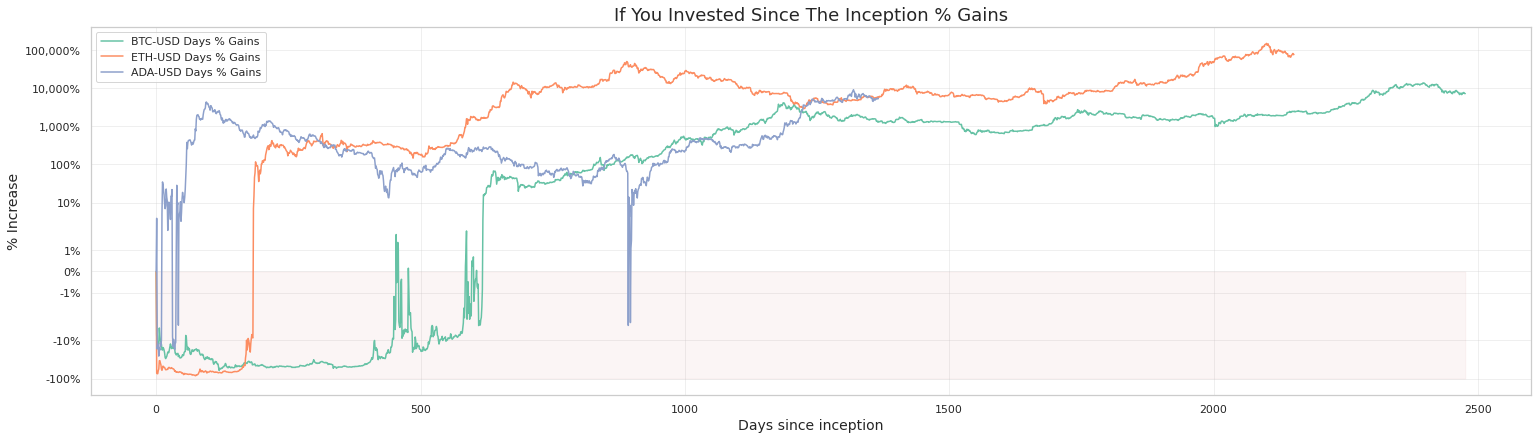

In [11]:
#hide_input
#@title Inception Gain
import matplotlib as mpl
df = pd.DataFrame()


ticks = ['BTC-USD',
         'ETH-USD',
         'ADA-USD']


for tickax in ticks:
  # data = pdr.get_data_yahoo(tickax, interval = '1d', period = "9y")
  # data = data.reset_index()
  # data = data.dropna()
  data = getdata(tickax,9)
  df[f'{tickax}%_day_Gain'] = 100*(data.Close - data.Close[0])/ data.Close[0]
df

sns.set_style("whitegrid")

fig = plt.figure()
fig.set_size_inches((20, 16))
ax1 = fig.add_axes((0, 0.72, 1, 0.32))

# Format x-axis ticks as dates
# ax1.xaxis_date()
n = 3
mpl.rcParams['axes.prop_cycle'] = plt.cycler("color", sns.color_palette("Set2"))


# Plot candlestick chart
for tickax in ticks:
  ax1.plot(df.index, df[f'{tickax}%_day_Gain'], label=f"{tickax} Days % Gains", alpha = 1)
ax1.fill_between(df.index, [0]*len(df.index), [-100]*len(df.index), color= '#bc4749', alpha = 0.05)  



# Set Y axis format 
ax1.set_title(f'If You Invested Since The Inception % Gains', size=18)
ax1.set_ylabel(f'% Increase', size=14)
ax1.set_xlabel('Days since inception', size=14)
ax1.set_yscale('symlog')
ax1.get_yaxis().set_major_formatter(
  ticker.FuncFormatter(lambda x, p: format(int(x), ',') + '%'))
plt.grid(True, which="both", ls="-", alpha = 0.3)
plt.legend(loc = 'upper left')
plt.show()


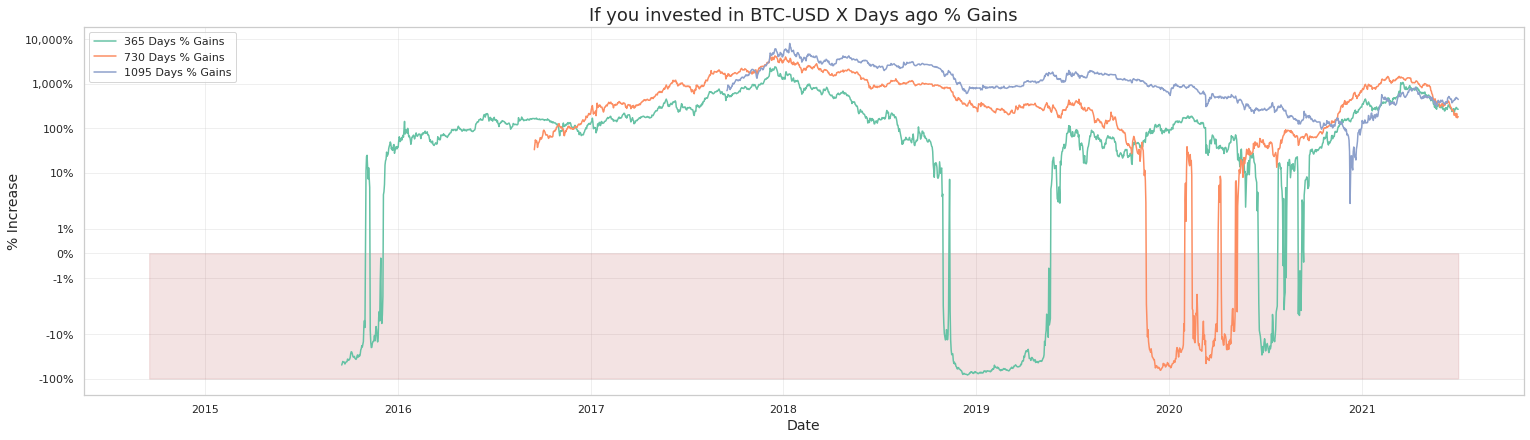

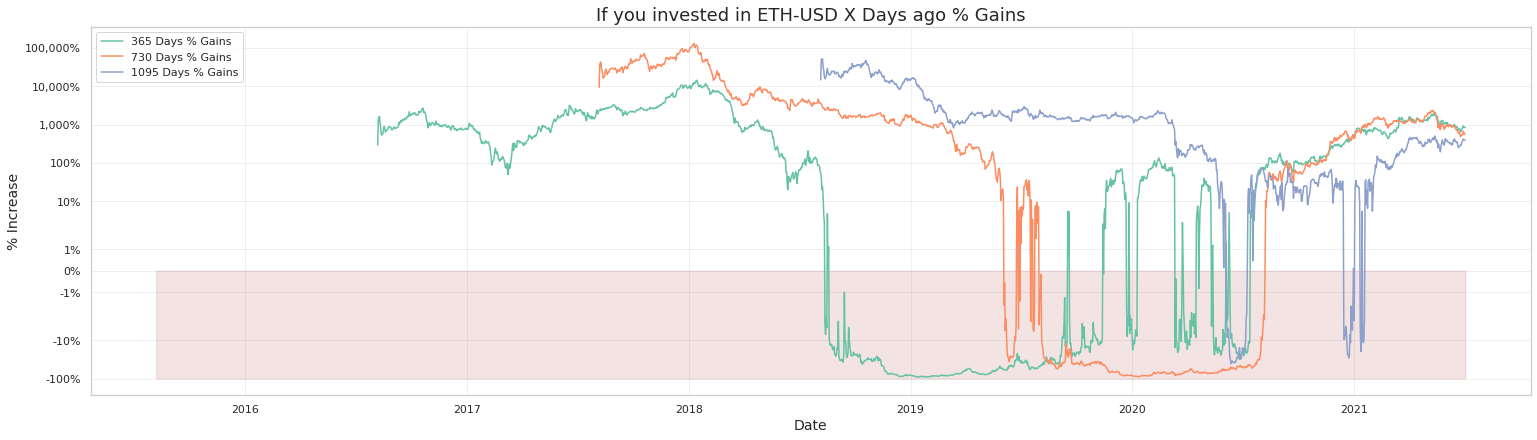

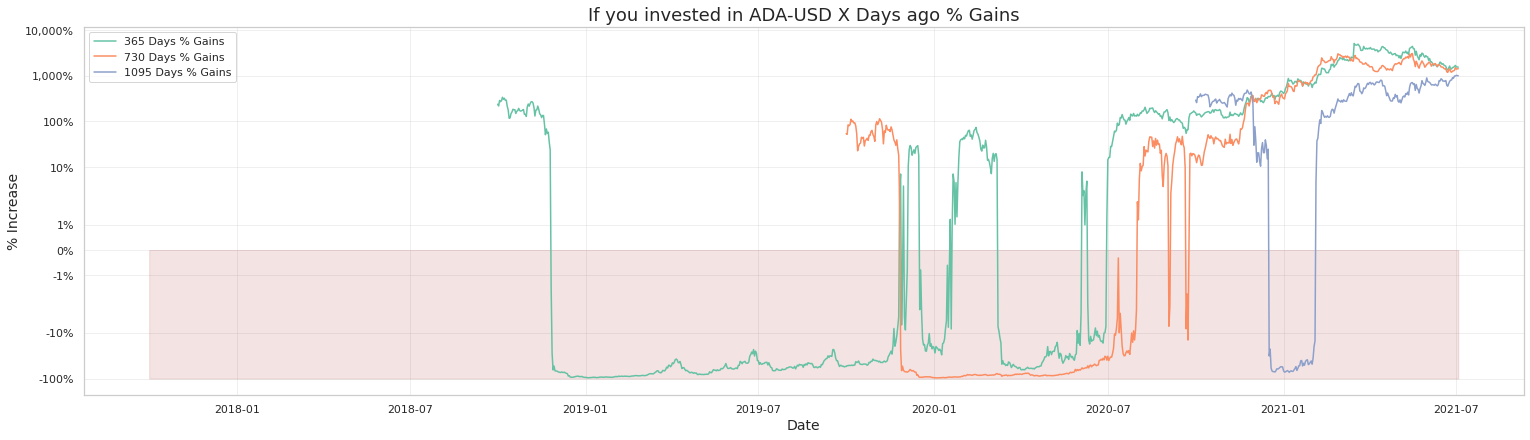

In [12]:
#hide_input
#@title X Days %Gain
# import matplotlib as mpl

df = pd.DataFrame()


ticks = ['BTC-USD',
         'ETH-USD',
         'ADA-USD']

# for time in [30,60,90,180,365,365*3]:       

for tickax in ticks:
  # data = pdr.get_data_yahoo(tickax, interval = '1d', period = "9y")
  # data = data.reset_index()
  # # data['Close_s'] = data.Close.shift(time)
  # data = data.dropna()
  data = getdata(tickax,9)
  # df[f'{tickax}%_{time}day_Gain'] = 100*(data.Close - data.Close_s)/ data.Close_s
  # df[f'{tickax}%_{time}day_Gain'] = (data.Close_s - data.Close[0])/ data.Close[0]

# Style and size

  # df[df == 0] = None
  # df[df == 'NaN'] = None
  sns.set_style("whitegrid")

  fig = plt.figure()
  fig.set_size_inches((20, 16))
  ax1 = fig.add_axes((0, 0.72, 1, 0.32))

  # Format x-axis ticks as dates
  # ax1.xaxis_date()
  n = 3
  mpl.rcParams['axes.prop_cycle'] = plt.cycler("color", sns.color_palette("Set2"))


  # Plot candlestick chart
  for time in [365,365*2,365*3]:  
    data['Close_s'] = data.Close.shift(time) 
    data[f'{tickax}%_{time}day_Gain'] = 100*(data.Close - data.Close_s)/ data.Close_s
    ax1.plot(data.Date, data[f'{tickax}%_{time}day_Gain'], label=f"{time} Days % Gains", alpha = 1)
    ax1.fill_between(data.Date, [0]*len(data.Date), [-100]*len(data.Date), color= '#bc4749', alpha = 0.05)  



  # Set Y axis format 
  ax1.set_title(f'If you invested in {tickax} X Days ago % Gains', size=18)
  ax1.set_ylabel(f'% Increase', size=14)
  ax1.set_xlabel('Date', size=14)
  ax1.set_yscale('symlog')
  ax1.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ',') + '%'))
  plt.grid(True, which="both", ls="-", alpha = 0.3)
  plt.legend(loc = 'upper left')
  plt.show()


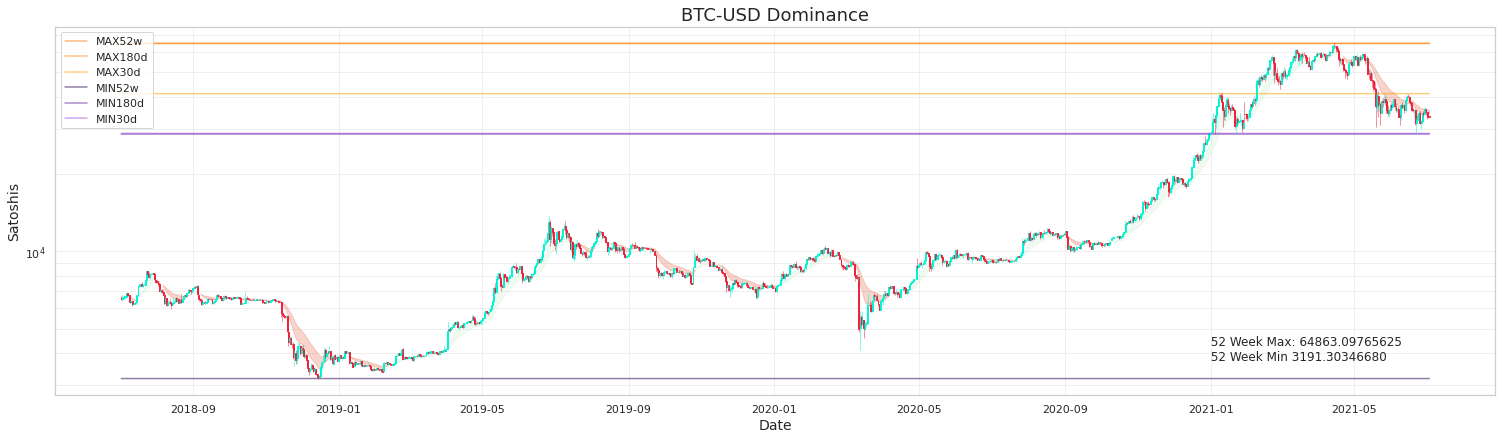

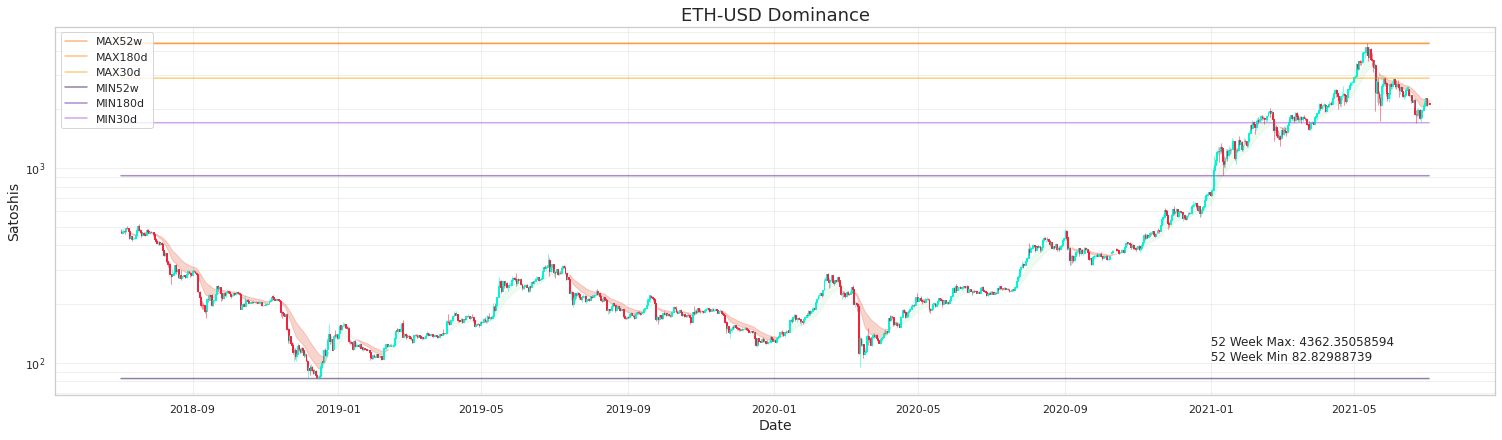

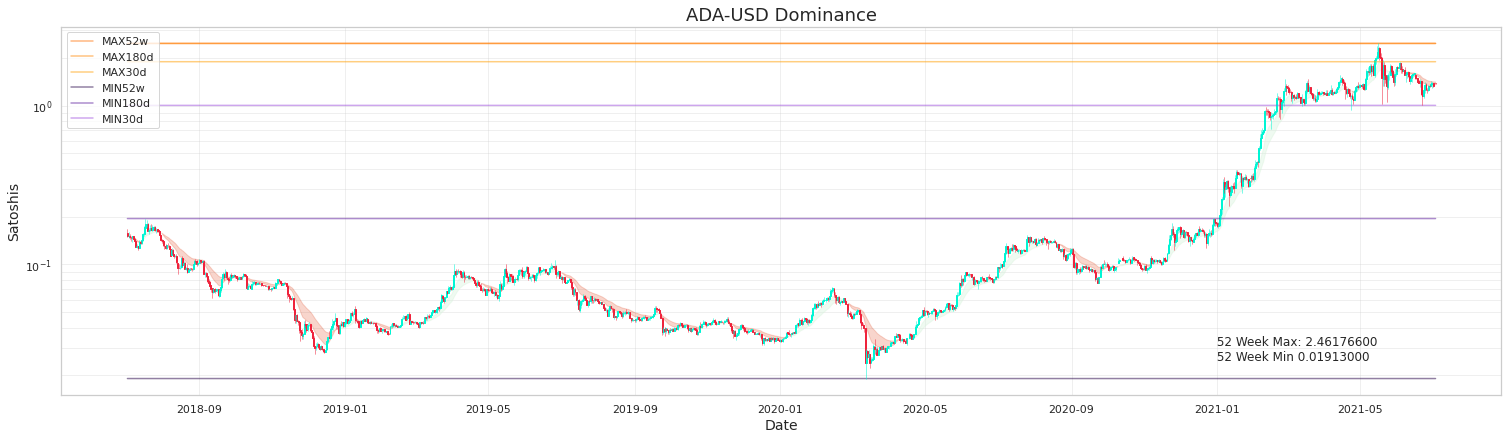

In [14]:
#hide_input
#@title X Days %Gain
import matplotlib as mpl
df = pd.DataFrame()


ticks = ['BTC-USD',
         'ETH-USD',
         'ADA-USD']


# for time in [30,60,90,180,365,365*3]:       


for tickax in ticks:
  yf.pdr_override() 
  data =  pdr.get_data_yahoo(tickax, interval = '1d', period = "3y",  progress=False)
  max52 = max(data.High)
  min52 = min(data.Low)
  df = data.reset_index()
  max30 = max(df.tail(30)['High'])
  min30 = min(df.tail(30)['Low'])
  max180 = max(df.tail(180)['High'])
  min180 = min(df.tail(180)['Low'])


  data = data.dropna()

  sns.set_style("whitegrid")

  fig = plt.figure()
  fig.set_size_inches((20, 16))
  ax1 = fig.add_axes((0, 0.72, 1, 0.32))

  n = 3
  mpl.rcParams['axes.prop_cycle'] = plt.cycler("color", sns.color_palette("Set2"))

  ohlc = []
  for date, row in data.iterrows():
    openp, highp, lowp, closep = row[:4]
    ohlc.append([date2num(date), openp, highp, lowp, closep])

  data["EMA12"] = data['Close'].ewm(span=12).mean()
  data["EMA26"] = data['Close'].ewm(span=26).mean()
  ax1.fill_between(data.index, data["EMA12"], data["EMA26"], where=(data["EMA12"]>data["EMA26"]), color= '#d8f3dc', alpha = 0.4)
  ax1.fill_between(data.index, data["EMA12"], data["EMA26"], where=(data["EMA12"]<data["EMA26"]), color= '#dc2f02', alpha = 0.2)
  ax1.plot(data.index,[max52]*len(data.index) , color= '#ff6d00', label=f"MAX52w", alpha = 0.5)
  ax1.plot(data.index,[max180]*len(data.index) , color= '#ff8500', label=f"MAX180d", alpha = 0.5)
  ax1.plot(data.index,[max30]*len(data.index) , color= '#ff9e00', label=f"MAX30d", alpha = 0.5)
  ax1.plot(data.index,[min52]*len(data.index) , color= '#240046', label=f"MIN52w", alpha = 0.5)
  ax1.plot(data.index,[min180]*len(data.index) , color= '#5a189a', label=f"MIN180d", alpha = 0.5)
  ax1.plot(data.index,[min30]*len(data.index) , color= '#9d4edd', label=f"MIN30d", alpha = 0.5)



  candlestick_ohlc(ax1, ohlc, colorup="#00f5d4", colordown="#ef233c", width=0.8)

  fig.text(0.8, 0.75, f'\n 52 Week Max: {max52:.8f} \n 52 Week Min {min52:.8f}')


  # Set Y axis format 
  ax1.set_title(f'{tickax} Dominance', size=18)
  ax1.set_ylabel(f'Satoshis', size=14)
  ax1.set_xlabel('Date', size=14)
  ax1.set_yscale('log')
  plt.grid(True, which="both", ls="-", alpha = 0.3)
  plt.legend(loc = 'upper left')
  plt.show()


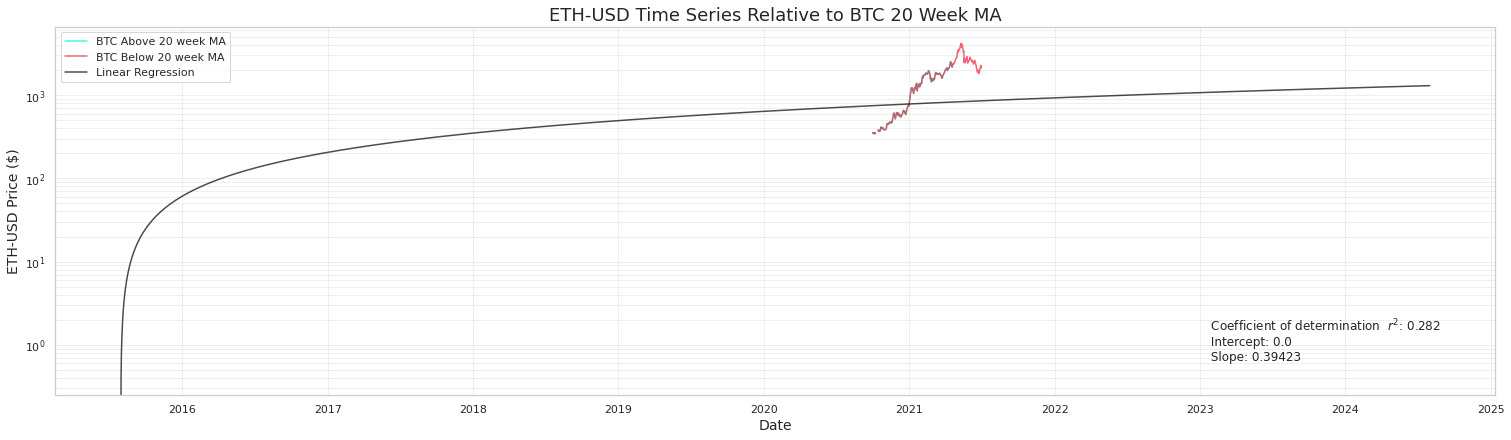

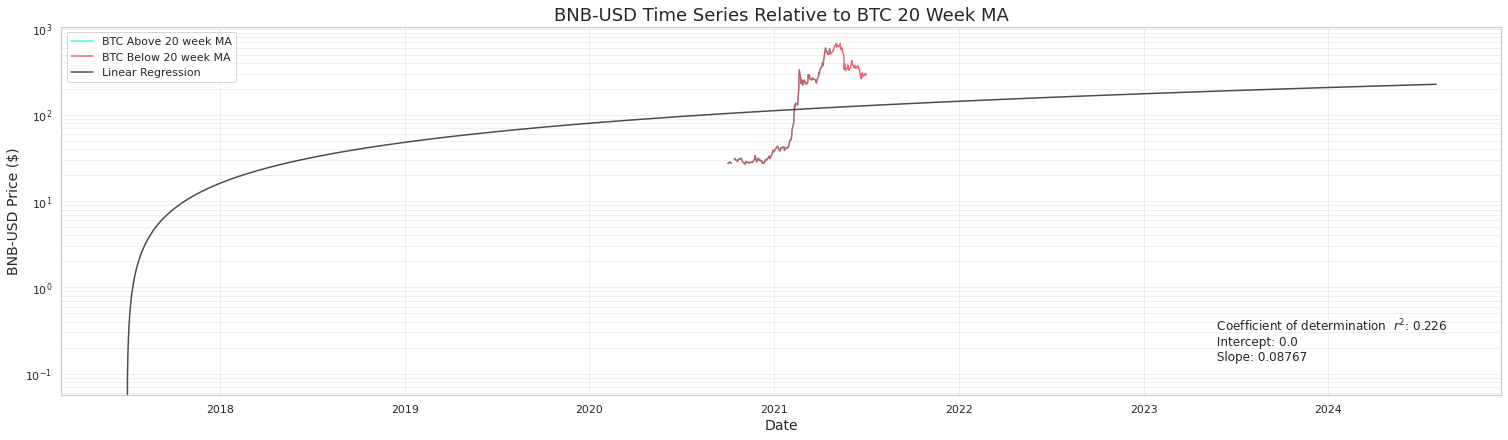

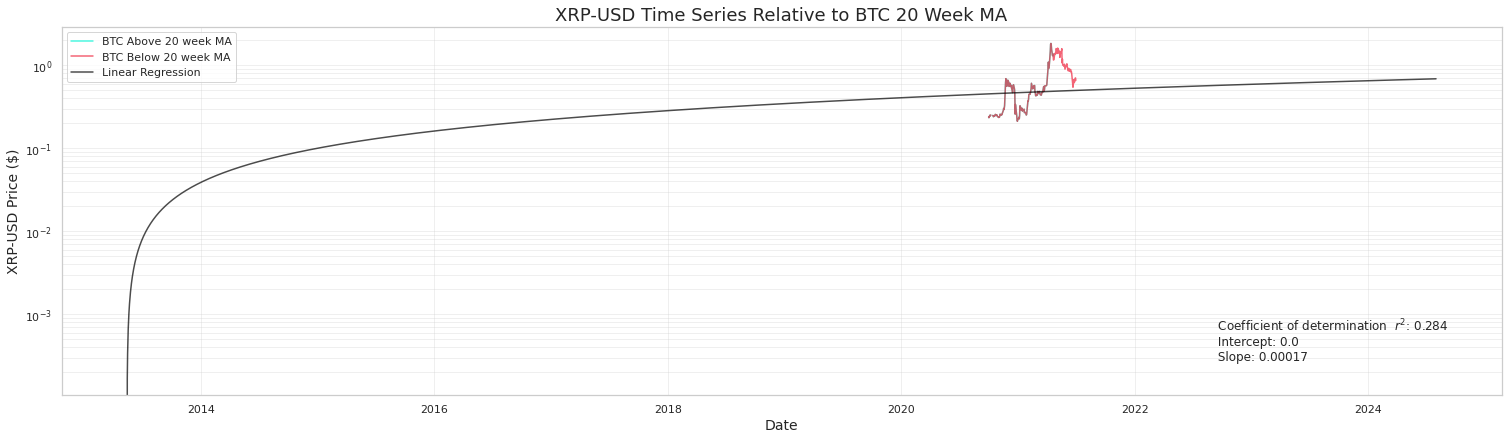

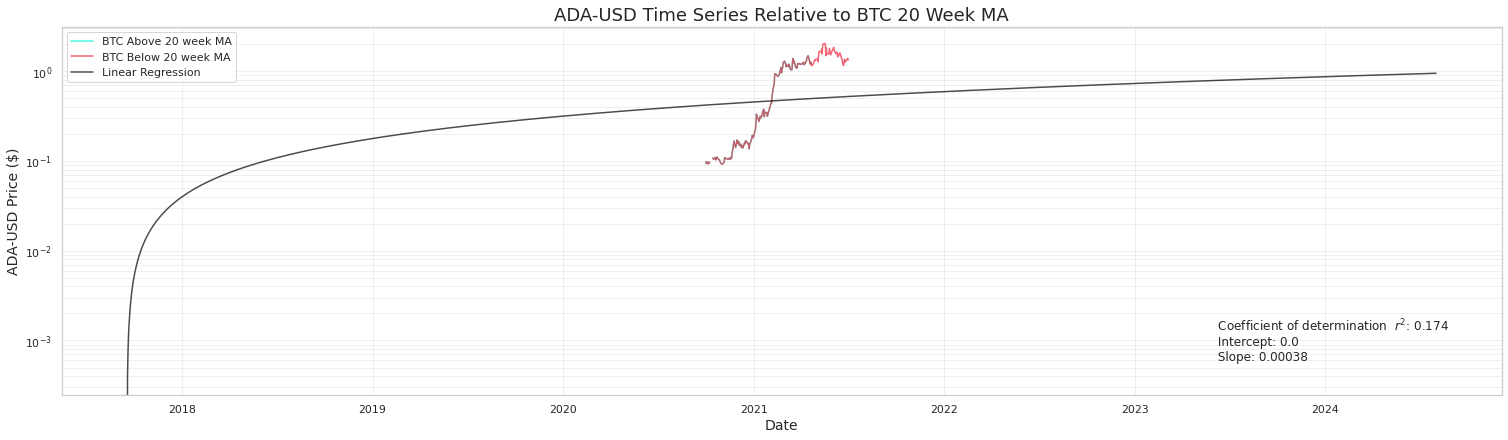

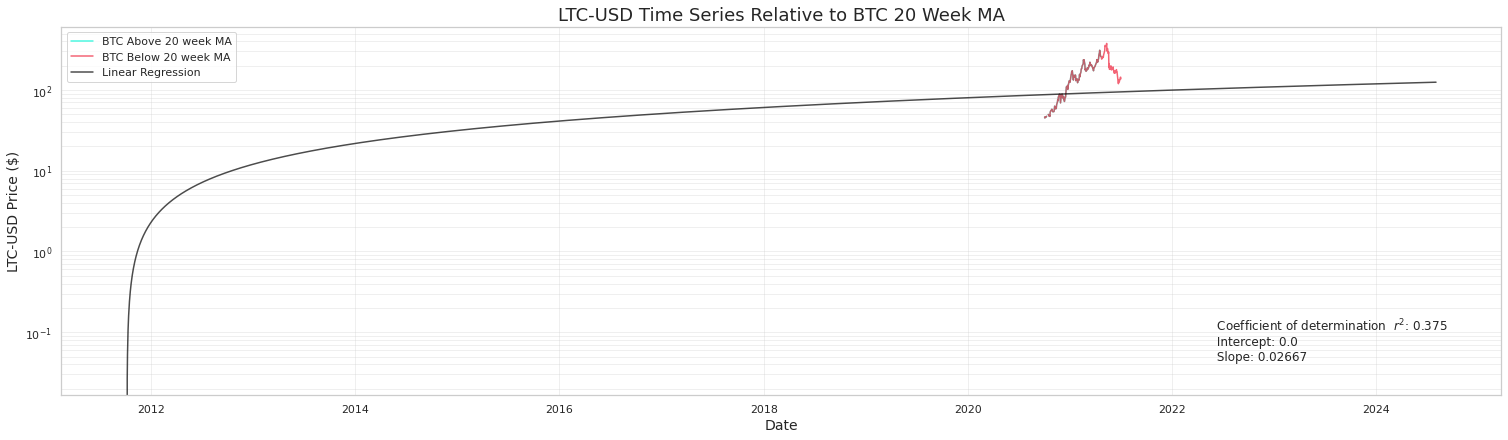

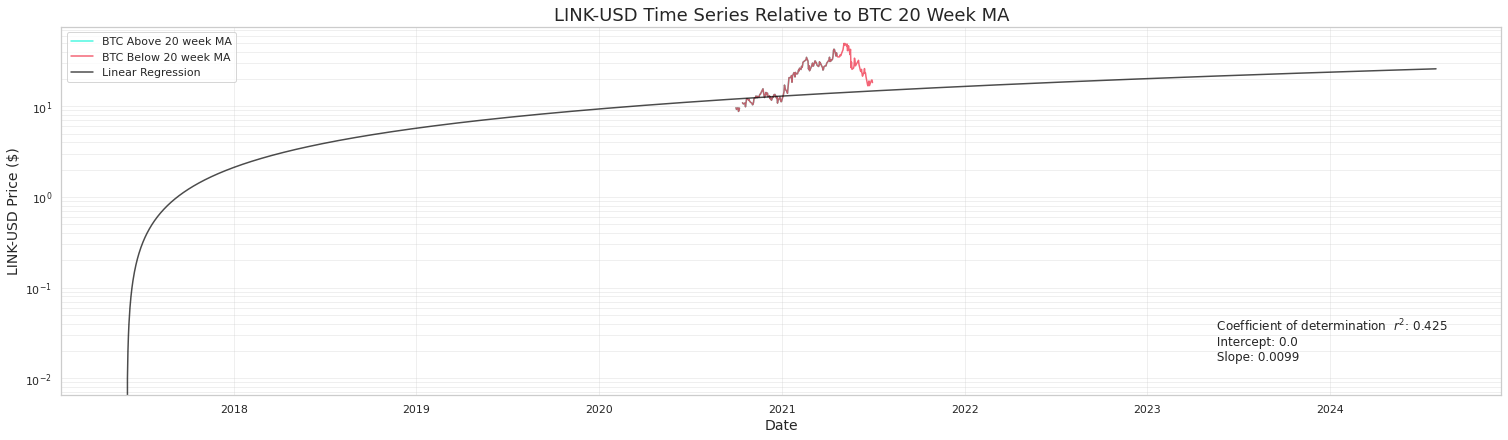

In [20]:
#hide
#@title LOG FIT Estimate



ticks = ['ETH-USD','BNB-USD',
         'XRP-USD', 'ADA-USD', 
         'LTC-USD','LINK-USD']

inception = ["2015-07-30", "2017-07-01", 
             "2013-05-15", "2017-09-17",
             "2011-10-07", "2017-06-01"]


yf.pdr_override() 
for tickax,incept in zip(ticks,inception): 

  # BTC = pdr.get_data_yahoo('BTC-USD', interval = '1d', period = "9y")
  # BTC['MA20'] = BTC['Close'].rolling(window=140).mean()
  # BTC
  # data = pdr.get_data_yahoo(tickax, interval = '1d', period = "9y")

  # BTC['GMA20'] = data['Adj Close']
  # BTC['LMA20'] = data['Adj Close']
  # BTC.loc[BTC['Adj Close'] > BTC['MA20'],'LMA20'] = None
  # BTC.loc[BTC['Adj Close'] < BTC['MA20'],'GMA20'] = None

  # y =  np.array(data['Adj Close'])
  # x = mdates.date2num(data.index)
  # p4 = np.poly1d(np.polyfit(x, np.log(y), 1))
  # xx = np.linspace(x.min(), x.max(), 100)
  # dd = mdates.num2date(xx)
  # data = BTC.copy()
  data = BTC20weekma(tickax)
  X, y, temp, pred, lg = logfit(tickax,incept)
  r_sq = lg.score(X, y)
  y[y == 0] = None

  


  # Style and size
  sns.set_style("whitegrid")
  
  fig = plt.figure()
  fig.set_size_inches((20, 16))
  ax1 = fig.add_axes((0, 0.72, 1, 0.32))

  # Format x-axis ticks as dates
  ax1.xaxis_date()


  # Plot candlestick chart
  ax1.plot(data.index, data['GMA20'], label=f"BTC Above 20 week MA",c = '#00f5d4', alpha = 0.7)
  ax1.plot(data.index, data['LMA20'], label=f"BTC Below 20 week MA",c = '#ef233c', alpha = 0.7)
  ax1.plot(temp.index, pred, c = '#000000', label='Linear Regression', alpha = 0.7)


  # Set Y axis format 
  ax1.set_title(f'{tickax} Time Series Relative to BTC 20 Week MA', size=18)
  ax1.set_ylabel(f'{tickax} Price ($)', size=14)
  ax1.set_xlabel('Date', size=14)
  ax1.set_yscale('log')
  fig.text(0.8, 0.75, f'\n Coefficient of determination $\ r^2 $: {round(r_sq,3)} \n Intercept: {lg.intercept_} \n Slope: {round(lg.coef_[0],5)}')
  plt.grid(True, which="both", ls="-", alpha = 0.3)
  plt.legend(loc = 'upper left')
  plt.show()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
                   BTC       ETH      LTC       XRP
Date                                               
2015-08-07  279.584991  2.772120  4.20828  0.008152
2015-08-08  260.997009  0.753325  3.85475  0.008476
2015-08-09  265.083008  0.701897  3.89859  0.008808
2015-08-10  264.470001  0.708448  3.94888  0.008750
2015-08-11  270.385986  1.067860  4.15955  0.008591
OrderedDict([('BTC', 0.63554), ('ETH', 0.35458), ('LTC', 0.0), ('XRP', 0.00988)])
Expected annual return: 90.2%
Annual volatility: 67.2%
Sharpe Ratio: 1.31
Discrete allocation: {'ETH': 2, 'XRP': 153}
Funds remaining: $5622.20


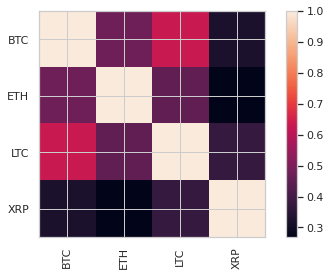

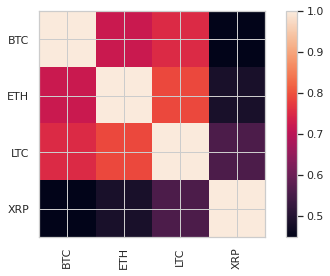

In [21]:
#hide
#@title Efficient Frontier

def getdata(tickax,n):
  yf.pdr_override() 
  data = pdr.get_data_yahoo(tickax, interval = '1d', period = f"{n}y")
  # data = data.reset_index()
  data = data.dropna()

  return data

ticks = ['BTC-USD','ETH-USD']


ticks = ['BTC', 'ETH', 'LTC', 'XRP']
ticks_dfs = []

for tick in ticks:
  ticks_price = pdr.get_data_yahoo(tick + '-USD', interval = '1d', period = "max")  
  ticks_price = ticks_price.drop(columns=['High', 'Low', 'Open', 'Close', 'Volume'])
  ticks_dfs.append(ticks_price)

all_ticks_prices = []
for ticks_df in ticks_dfs:
  all_ticks_prices.append(ticks_df['Adj Close'])

prices_df = pd.concat(all_ticks_prices, axis=1)
prices_df.columns = ticks
df = prices_df.dropna()
print(df.head())

# Calculate expected returns and sample covariance
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)

# Optimize for maximal Sharpe ratio
ef = EfficientFrontier(mu, S)
raw_weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
# ef.save_weights_to_file("weights.csv")  # saves to file
print(cleaned_weights)
ef.portfolio_performance(verbose=True)

from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

latest_prices = get_latest_prices(df)

da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=10000)
try:
  allocation, leftover = da.lp_portfolio()
  print("Discrete allocation:", allocation)
  print("Funds remaining: ${:.2f}".format(leftover))
except:
  pass

from pypfopt import risk_models, expected_returns, plotting
past_df, future_df = df.iloc[:-250], df.iloc[-250:]
future_cov = risk_models.sample_cov(future_df)
sample_cov = risk_models.sample_cov(past_df)
plotting.plot_covariance(sample_cov, plot_correlation=True)
plotting.plot_covariance(future_cov, plot_correlation=True)
plt.show()

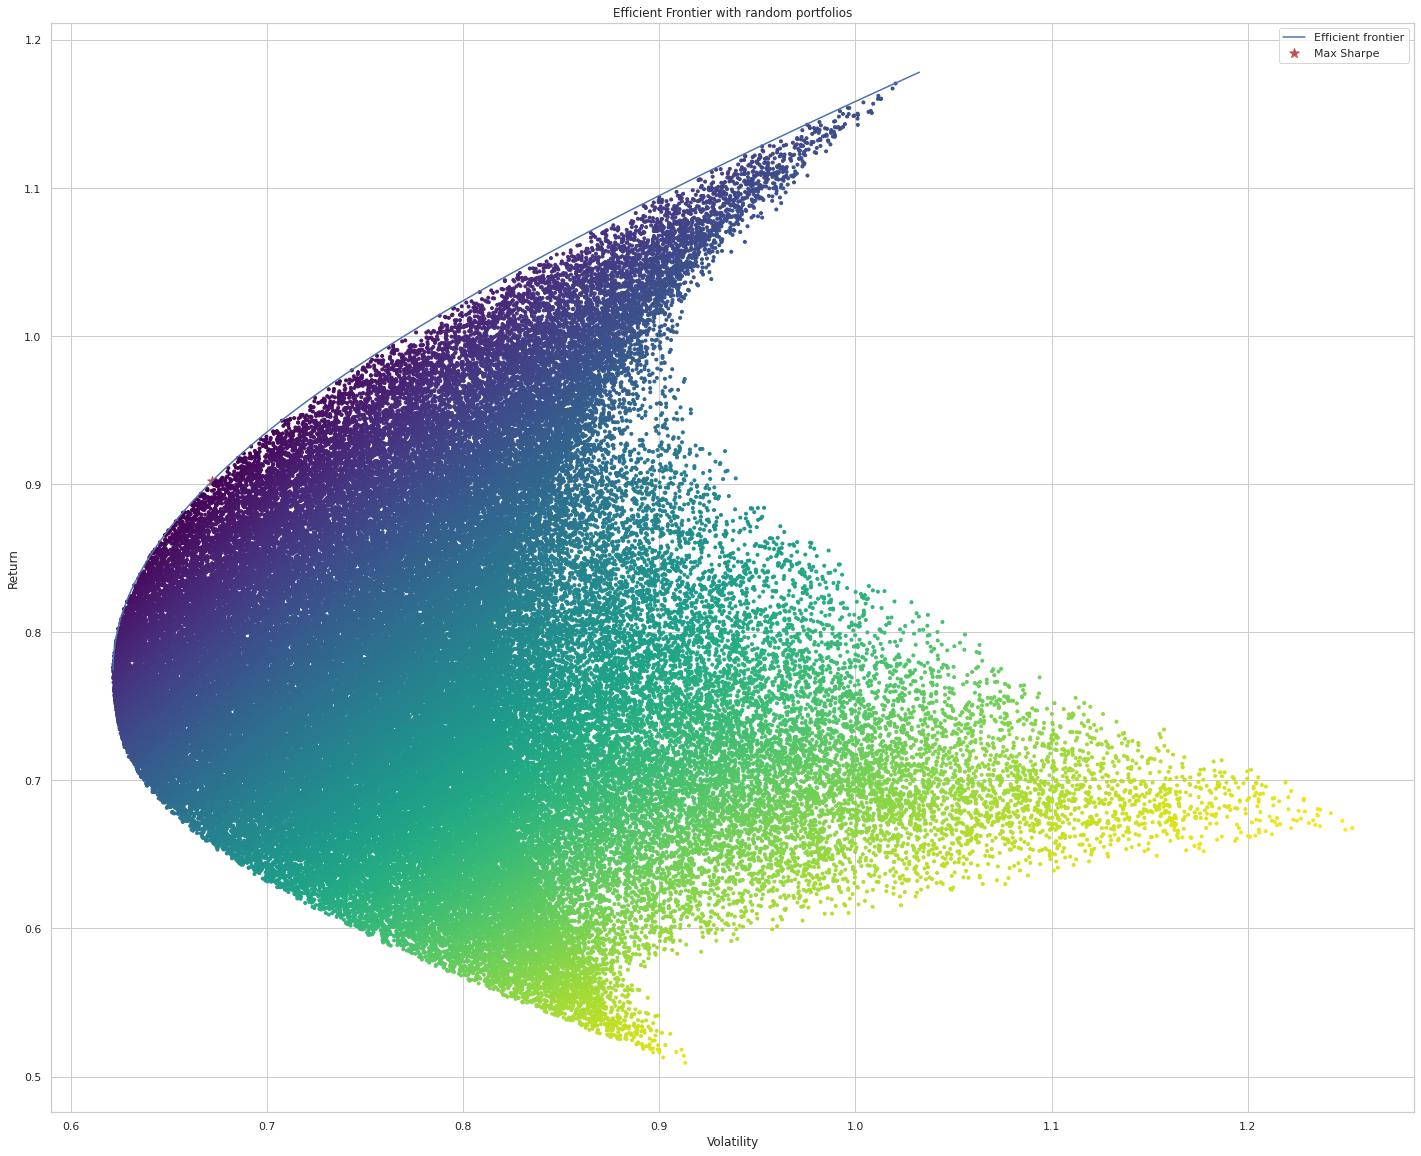

In [22]:
#hide
#@title EF PLOT

n_samples = 100000
w = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets = w.dot(mu)
stds = np.sqrt((w.T * (S @ w.T)).sum(axis=0))
sharpes = rets / stds

# Plot efficient frontier with Monte Carlo sim
ef = EfficientFrontier(mu, S)

fig, ax = plt.subplots()
fig.set_size_inches((20, 16))
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find and plot the tangency portfolio
ef.max_sharpe()
ret_tangent, std_tangent, _ = ef.portfolio_performance()

ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Plot random portfolios
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Format
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
# plt.tight_layout()
plt.show()


In [24]:
#hide
from datetime import datetime
import requests
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
import re
day = datetime.today().strftime('%d %m %Y')[0:2]
mon = datetime.today().strftime('%d %m %Y')[3:5]
yr = datetime.today().strftime('%d %m %Y')[6:10]

No handles with labels found to put in legend.


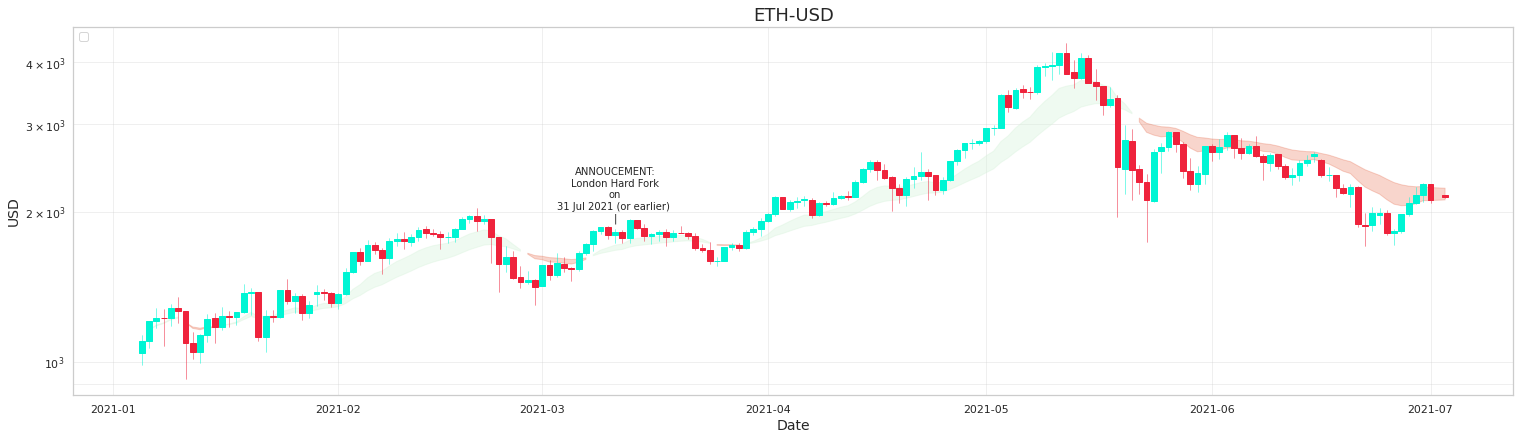

In [31]:
#hide_input
#@title ETH NEWS


ethurl = f'https://coinmarketcal.com/en/?form%5Bdate_range%5D={day}%2F{mon}%2F{yr}+-+01%2F08%2F2024&form%5Bkeyword%5D=&form%5Bcoin%5D%5B%5D=ethereum&form%5Bsort_by%5D=&form%5Bsubmit%5D='

ethurl
URL = ethurl
hdr = {'User-Agent': 'Mozilla/5.0'}
req = Request(URL,headers=hdr)
page = urlopen(req)

soup = BeautifulSoup(page, 'html.parser')

# print(soup)
results = soup.find_all('article')

df = pd.DataFrame(columns = ['EventDate', 'EventTitle', 'EventAdded'] )

for job_elem in results:
  eventdate = job_elem.find_all(class_ ="card__date mt-0")
  eventdate = re.search('>(.*)<',str(eventdate)).group(1)
  eventtitle = job_elem.find_all(class_ ="card__title mb-0 ellipsis")
  eventtitle = re.search('>(.*)<',str(eventtitle)).group(1)
  adddate = job_elem.find_all(class_= 'added-date')
  adddate = re.search('>(.*)<',str(adddate)).group(1)
  d = {'EventDate':eventdate , 'EventTitle':eventtitle, 'EventAdded':adddate[6:]}
  d = pd.DataFrame(d,index=[0])
  df = df.append(d)

df['EventAdded'] = pd.to_datetime(df['EventAdded'], format= ' %d %b %Y')

tickax= 'ETH-USD'

yf.pdr_override() 
data =  pdr.get_data_yahoo(tickax, interval = '1d', period = "180d", progress=False)

sns.set_style("whitegrid")

fig = plt.figure()
fig.set_size_inches((20, 16))
ax1 = fig.add_axes((0, 0.72, 1, 0.32))

n = 3
mpl.rcParams['axes.prop_cycle'] = plt.cycler("color", sns.color_palette("Set2"))

ohlc = []
for date, row in data.iterrows():
  openp, highp, lowp, closep = row[:4]
  ohlc.append([date2num(date), openp, highp, lowp, closep])


candlestick_ohlc(ax1, ohlc, colorup="#00f5d4", colordown="#ef233c", width=0.8)


data["EMA12"] = data['Close'].ewm(span=12).mean()
data["EMA26"] = data['Close'].ewm(span=26).mean()
ax1.fill_between(data.index, data["EMA12"], data["EMA26"], where=(data["EMA12"]>data["EMA26"]), color= '#d8f3dc', alpha = 0.4)
ax1.fill_between(data.index, data["EMA12"], data["EMA26"], where=(data["EMA12"]<data["EMA26"]), color= '#dc2f02', alpha = 0.2)


data = pd.concat([df.set_index('EventAdded'),data],axis=1)
text = data[~data['EventTitle'].isna()]

for i in range(len(text)):
  e= text['EventTitle'][i]
  ed = text['EventDate'][i]
  ax1.text(text.index[i], text['Close'][i]*1.05, f'ANNOUCEMENT:\n{e}\non\n{ed}\n|', fontsize=10, horizontalalignment='center')





# Set Y axis format 
ax1.set_title(f'{tickax}', size=18)
ax1.set_ylabel(f'USD', size=14)
ax1.set_xlabel('Date', size=14)
ax1.set_yscale('log')
plt.grid(True, which="both", ls="-", alpha = 0.3)
plt.legend(loc = 'upper left')
plt.show()

No handles with labels found to put in legend.


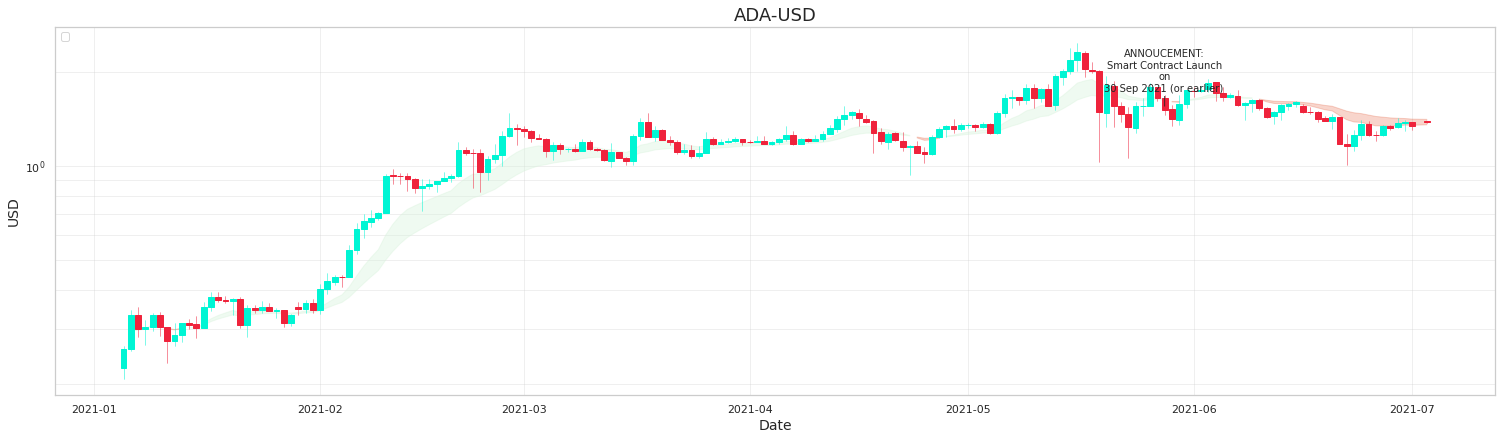

In [30]:
#hide_input
#@title ADA NEWS


ADAurl = f'https://coinmarketcal.com/en/?form%5Bdate_range%5D={day}%2F{mon}%2F{yr}+-+01%2F08%2F2024&form%5Bkeyword%5D=&form%5Bcoin%5D%5B%5D=cardano&form%5Bsort_by%5D=&form%5Bsubmit%5D=&form%5Bshow_reset%5D='

ADAurl
URL = ADAurl
hdr = {'User-Agent': 'Mozilla/5.0'}
req = Request(URL,headers=hdr)
page = urlopen(req)

soup = BeautifulSoup(page, 'html.parser')

# print(soup)
results = soup.find_all('article')

df = pd.DataFrame(columns = ['EventDate', 'EventTitle', 'EventAdded'] )

for job_elem in results:
  eventdate = job_elem.find_all(class_ ="card__date mt-0")
  eventdate = re.search('>(.*)<',str(eventdate)).group(1)
  eventtitle = job_elem.find_all(class_ ="card__title mb-0 ellipsis")
  eventtitle = re.search('>(.*)<',str(eventtitle)).group(1)
  adddate = job_elem.find_all(class_= 'added-date')
  adddate = re.search('>(.*)<',str(adddate)).group(1)
  d = {'EventDate':eventdate , 'EventTitle':eventtitle, 'EventAdded':adddate[6:]}
  d = pd.DataFrame(d,index=[0])
  df = df.append(d)

df['EventAdded'] = pd.to_datetime(df['EventAdded'], format= ' %d %b %Y')


tickax= 'ADA-USD'

yf.pdr_override() 
data =  pdr.get_data_yahoo(tickax, interval = '1d', period = "180d", progress=False)

sns.set_style("whitegrid")

fig = plt.figure()
fig.set_size_inches((20, 16))
ax1 = fig.add_axes((0, 0.72, 1, 0.32))

n = 3
mpl.rcParams['axes.prop_cycle'] = plt.cycler("color", sns.color_palette("Set2"))

ohlc = []
for date, row in data.iterrows():
  openp, highp, lowp, closep = row[:4]
  ohlc.append([date2num(date), openp, highp, lowp, closep])


candlestick_ohlc(ax1, ohlc, colorup="#00f5d4", colordown="#ef233c", width=0.8)


data["EMA12"] = data['Close'].ewm(span=12).mean()
data["EMA26"] = data['Close'].ewm(span=26).mean()
ax1.fill_between(data.index, data["EMA12"], data["EMA26"], where=(data["EMA12"]>data["EMA26"]), color= '#d8f3dc', alpha = 0.4)
ax1.fill_between(data.index, data["EMA12"], data["EMA26"], where=(data["EMA12"]<data["EMA26"]), color= '#dc2f02', alpha = 0.2)


data = pd.concat([df.set_index('EventAdded'),data],axis=1)
text = data[~data['EventTitle'].isna()]

for i in range(len(text)):
  e= text['EventTitle'][i]
  ed = text['EventDate'][i]
  ax1.text(text.index[i], text['Close'][i]*1.05, f'ANNOUCEMENT:\n{e}\non\n{ed}\n|', fontsize=10, horizontalalignment='center')





# Set Y axis format 
ax1.set_title(f'{tickax}', size=18)
ax1.set_ylabel(f'USD', size=14)
ax1.set_xlabel('Date', size=14)
ax1.set_yscale('log')
plt.grid(True, which="both", ls="-", alpha = 0.3)
plt.legend(loc = 'upper left')
plt.show()

[*********************100%***********************]  1 of 1 completed
                Open      High       Low  ...     Volume     EMA12     EMA26
Date                                      ...                               
2020-07-03  0.038261  0.040500  0.037790  ...    8163859  0.039729  0.039729
2020-07-04  0.039762  0.041257  0.039275  ...    9112617  0.040492  0.040460
2020-07-05  0.041131  0.041131  0.038847  ...    7544986  0.040108  0.040118
2020-07-06  0.039509  0.040393  0.039223  ...    8364219  0.040145  0.040148
2020-07-07  0.040343  0.041279  0.039418  ...    7485929  0.040254  0.040241
...              ...       ...       ...  ...        ...       ...       ...
2021-06-28  0.182241  0.184777  0.176054  ...  143579574  0.185602  0.200566
2021-06-29  0.182558  0.195802  0.181621  ...  152042580  0.186244  0.199766
2021-06-30  0.190595  0.195359  0.176540  ...  188821623  0.187646  0.199440
2021-07-01  0.195415  0.213540  0.182808  ...  251308009  0.191434  0.200390
2021-07

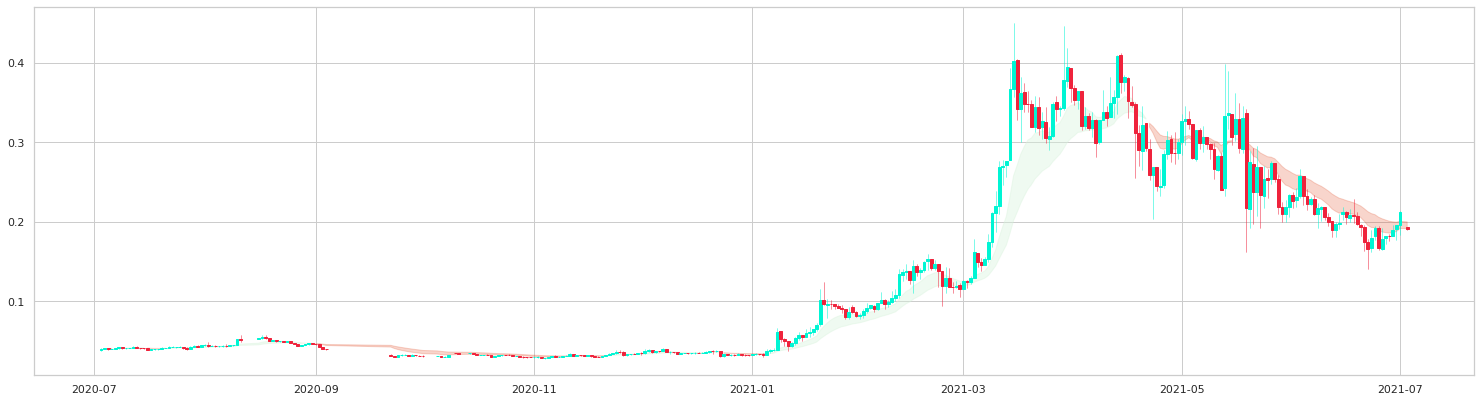

In [29]:
#hide
#@title HBAR NEWS


ADAurl = f'https://coinmarketcal.com/en/?form%5Bdate_range%5D={day}%2F{mon}%2F{yr}+-+01%2F08%2F2024&form%5Bkeyword%5D=&form%5Bcoin%5D%5B%5D=hedera-hashgraph&form%5Bsort_by%5D=&form%5Bsubmit%5D=&form%5Bshow_reset%5D='

ADAurl
URL = ADAurl
hdr = {'User-Agent': 'Mozilla/5.0'}
req = Request(URL,headers=hdr)
page = urlopen(req)

soup = BeautifulSoup(page, 'html.parser')

# print(soup)
results = soup.find_all('article')

df = pd.DataFrame(columns = ['EventDate', 'EventTitle', 'EventAdded'] )

for job_elem in results:
  eventdate = job_elem.find_all(class_ ="card__date mt-0")
  eventdate = re.search('>(.*)<',str(eventdate)).group(1)
  eventtitle = job_elem.find_all(class_ ="card__title mb-0 ellipsis")
  eventtitle = re.search('>(.*)<',str(eventtitle)).group(1)
  adddate = job_elem.find_all(class_= 'added-date')
  adddate = re.search('>(.*)<',str(adddate)).group(1)
  d = {'EventDate':eventdate , 'EventTitle':eventtitle, 'EventAdded':adddate[6:]}
  d = pd.DataFrame(d,index=[0])
  df = df.append(d)

df['EventAdded'] = pd.to_datetime(df['EventAdded'], format= ' %d %b %Y')


tickax= 'HBAR-USD'

yf.pdr_override() 
data =  pdr.get_data_yahoo(tickax, interval = '1d', period = "1y")

sns.set_style("whitegrid")

fig = plt.figure()
fig.set_size_inches((20, 16))
ax1 = fig.add_axes((0, 0.72, 1, 0.32))

n = 3
mpl.rcParams['axes.prop_cycle'] = plt.cycler("color", sns.color_palette("Set2"))

ohlc = []
for date, row in data.iterrows():
  openp, highp, lowp, closep = row[:4]
  ohlc.append([date2num(date), openp, highp, lowp, closep])


candlestick_ohlc(ax1, ohlc, colorup="#00f5d4", colordown="#ef233c", width=0.8)


data["EMA12"] = data['Close'].ewm(span=12).mean()
data["EMA26"] = data['Close'].ewm(span=26).mean()
ax1.fill_between(data.index, data["EMA12"], data["EMA26"], where=(data["EMA12"]>data["EMA26"]), color= '#d8f3dc', alpha = 0.4)
ax1.fill_between(data.index, data["EMA12"], data["EMA26"], where=(data["EMA12"]<data["EMA26"]), color= '#dc2f02', alpha = 0.2)

print(data)
print(df)
data = pd.concat([df.set_index('EventAdded'),data])
text = data[~data['EventTitle'].isna()]
print(text)
# for i in range(len(text)):
#   e= text['EventTitle'][i]
#   ed = text['EventDate'][i]
#   ax1.text(text.index[i], text['Close'][i]*1.05, f'ANNOUCEMENT:\n{e}\non\n{ed}\n|', fontsize=10, horizontalalignment='center')





# # Set Y axis format 
# ax1.set_title(f'{tickax}', size=18)
# ax1.set_ylabel(f'USD', size=14)
# ax1.set_xlabel('Date', size=14)
# ax1.set_yscale('log')
# plt.grid(True, which="both", ls="-", alpha = 0.3)
# plt.legend(loc = 'upper left')
# plt.show()